## Importing Required Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


### Loading dataset 

In [37]:
df = pd.read_csv("fraud.csv")
df.head()
# print(df.info())

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Data Cleaning - Null Values Check

In [38]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### Checked for transactions with zero balances in oldbalanceOrg and newbalanceDest

In [39]:
df[df['oldbalanceOrg']==0].count()

step              2102449
type              2102449
amount            2102449
nameOrig          2102449
oldbalanceOrg     2102449
newbalanceOrig    2102449
nameDest          2102449
oldbalanceDest    2102449
newbalanceDest    2102449
isFraud           2102449
isFlaggedFraud    2102449
dtype: int64

In [40]:
df[df['oldbalanceOrg']==0]['isFraud'].value_counts(normalize=True)

isFraud
0    0.99998
1    0.00002
Name: proportion, dtype: float64

In [41]:
df[df['newbalanceDest']==0].count()



step              2439433
type              2439433
amount            2439433
nameOrig          2439433
oldbalanceOrg     2439433
newbalanceOrig    2439433
nameDest          2439433
oldbalanceDest    2439433
newbalanceDest    2439433
isFraud           2439433
isFlaggedFraud    2439433
dtype: int64

In [42]:
df[df['newbalanceDest']==0]['isFraud'].value_counts(normalize=True)

isFraud
0    0.998323
1    0.001677
Name: proportion, dtype: float64

In [43]:
df.groupby(df['newbalanceDest']==0)['isFraud'].mean()

newbalanceDest
False    0.001051
True     0.001677
Name: isFraud, dtype: float64

### Observations

oldbalanceOrg == 0: 99.998% non-fraud, very few fraud cases.

newbalanceDest == 0: fraud slightly higher (0.1677%) than overall rate (~0.105%), but still very low.

Overall dataset is highly imbalanced: ~0.167% fraud.


### Creating a Zero-Balance Flag for `oldbalanceOrg`

Want to capture transactions where the sender's account balance before the transaction is zero, because this can be an important signal for fraud detection.

In [44]:
df['isZeroOldBalance'] = (df['oldbalanceOrg'] == 0).astype(int)

In [45]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isZeroOldBalance
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0


### Creating the Balance Difference Feature for Origin Account (`diffOrig`)

Want to capture inconsistencies in the sender's account balances, which can indicate suspicious or fraudulent transactions.



In [46]:
df['diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']


### Creating a Zero-Balance Flag for Destination Account (`isZeroNewBalanceDest`)

Want to capture transactions where the receiver's account balance after the transaction is zero, as this can be a subtle signal in fraud detection.

Purpose:

Although fraud rate is slightly higher when newbalanceDest is zero, the difference is small.

This feature allows the model to consider zero-destination-balance as a potential signal without letting raw values dominate predictions.

In [47]:
df['isZeroNewBalanceDest'] = (df['newbalanceDest'] == 0).astype(int)

### Creating the Balance Difference Feature for Destination Account (`diffDest`)

Want to capture inconsistencies in the receiver's account balances, which can indicate suspicious or potentially fraudulent transactions.

Purpose:

A non-zero diffDest may indicate anomalies, errors, or fraudulent activity in the destination account.

Including this feature helps the model detect irregularities in how money is received, complementing diffOrig for the sender.

In [48]:
df['diffDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']


### Checking for Duplicate Rows

We want to ensure that our dataset does not contain any exact duplicate transactions, which could bias the model or inflate the number of non-fraud cases.

```python
df.duplicated().sum()
output = 0

Purpose:

Confirms that every transaction in the dataset is unique, so no duplicates need to be dropped before training the model.


In [49]:
df.duplicated().sum()

np.int64(0)

### Log-Transformation of `amount` to Reduce Skewness

I observed that the `amount` feature in the provided dataset was highly right-skewed. Most transactions had relatively small amounts, while a few transactions had extremely large values. Many of these appeared as outliers in the initial boxplot.




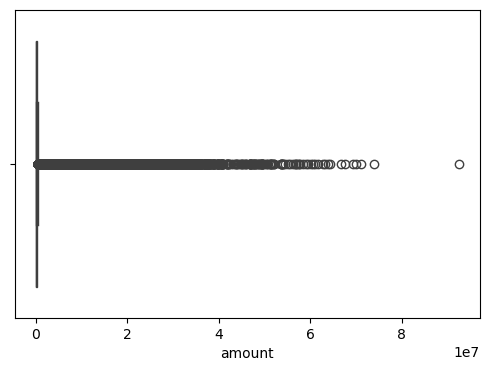

In [50]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["amount"])
plt.show()

#### Step 1: Create a Log-Transformed Column

In [52]:
# Log-transform the amount (adding 1 to handle zeros)
df['log_amount'] = np.log1p(df['amount'])

#### Observations:

After transformation, the distribution of transaction amounts became clearer.

Extreme values were compressed, and the majority of transactions were easier to interpret visually.

This helps in preparing the feature for machine learning, ensuring that high-value transactions do not disproportionately affect the model.

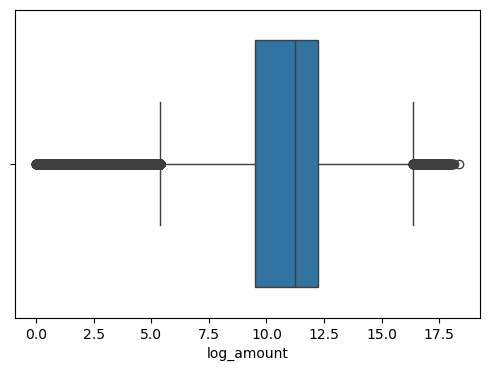

In [53]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["log_amount"])
plt.show()


### Dropping Raw Account IDs and Encoding Transaction Type

I decided to remove the raw account identifiers (`nameOrig` and `nameDest`) and encode the `type` column to prepare the dataset for machine learning.

Explanation:

nameOrig and nameDest are unique account IDs.

These IDs do not provide predictive value for fraud detection.

Removing them prevents the model from memorizing account-specific patterns, which could lead to overfitting.

The type column is categorical (e.g., CASH_OUT, TRANSFER, etc.).

Most ML algorithms require numeric input, so I converted the categories into integer labels using LabelEncoder.

This allows the model to learn patterns based on transaction type without using raw text.

Outcome:

The dataset now contains only numeric and engineered features, ready for scaling and modeling.

In [54]:
df = df.drop(["nameOrig","nameDest"], axis=1)
le = LabelEncoder()
df["type"] = le.fit_transform(df["type"])


In [57]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isZeroOldBalance,diffOrig,isZeroNewBalanceDest,diffDest,log_amount,errorBalanceOrig,errorBalanceDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1.455192e-11,1,9839.64,9.194276,0.0,9839.64
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,-1.136868e-12,1,1864.28,7.531166,0.0,1864.28
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0,0,0.000000e+00,1,181.00,5.204007,0.0,181.00
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,0.000000e+00,1,21363.00,5.204007,0.0,21363.00
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0.000000e+00,1,11668.14,9.364703,0.0,11668.14


### Creating Error Balance Features

I created two new features, `errorBalanceOrig` and `errorBalanceDest`, to capture discrepancies in account balances:

- **errorBalanceOrig:** Measures any inconsistency in the sender’s account after the transaction. A non-zero value may indicate suspicious activity.  
- **errorBalanceDest:** Measures any inconsistency in the receiver’s account after the transaction. Non-zero values can also signal irregularities.  

These features help the model detect potential fraud by highlighting transactions where the recorded balances do not match the expected values.


In [56]:
df["errorBalanceOrig"] = df["newbalanceOrig"] + df["amount"] - df["oldbalanceOrg"]
df["errorBalanceDest"] = df["oldbalanceDest"] + df["amount"] - df["newbalanceDest"]

### Preparing Features and Target

I split the dataset into features (`X`) and target (`y`) for modeling:

- **X:** All columns except `isFraud` and `isFlaggedFraud`.  
- **y:** The `isFraud` column, indicating if a transaction is fraudulent.  

Now, `X` has all the predictors and `y` has the labels, ready for scaling and model training.


In [58]:
X = df.drop(["isFraud","isFlaggedFraud"], axis=1)
y = df["isFraud"]


### Splitting the Dataset into Training and Test Sets

I split the data into training and test sets to evaluate the model properly:

- **Training set:** 70% of the data, used to train the model (`X_train`, `y_train`).  
- **Test set:** 30% of the data, used to evaluate model performance (`X_test`, `y_test`).  
- I used **stratification** to ensure the proportion of fraudulent and non-fraudulent transactions is the same in both sets.  
- `random_state=42` ensures reproducibility of the split.


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


### Scaling Features and Handling Imbalance

I scaled all numeric features using `StandardScaler` to make their ranges similar.  

Since fraud is rare, I handled class imbalance by either using **class weights** or **oversampling** the minority class.  

This helps the model learn to detect fraud better.


In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Training a Logistic Regression Model

I trained a Logistic Regression model to detect fraud:

- Set `max_iter=1000` to ensure convergence.  
- Used `class_weight="balanced"` to give more importance to the rare fraud cases.  
- The model was fitted on the training data (`X_train`, `y_train`).


In [61]:
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Making Predictions and Evaluating the Model

I used the trained Logistic Regression model to make predictions on the test set:

- `y_pred` gives the predicted classes.  
- `y_prob` gives the predicted probabilities for the positive (fraud) class.  

I evaluated the model using:  
- **Classification report** (precision, recall, F1-score)  
- **ROC-AUC score** to measure how well the model distinguishes fraud from non-fraud.


In [62]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1906322
           1       0.02      0.91      0.05      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.93      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786

ROC-AUC: 0.9822734303460228


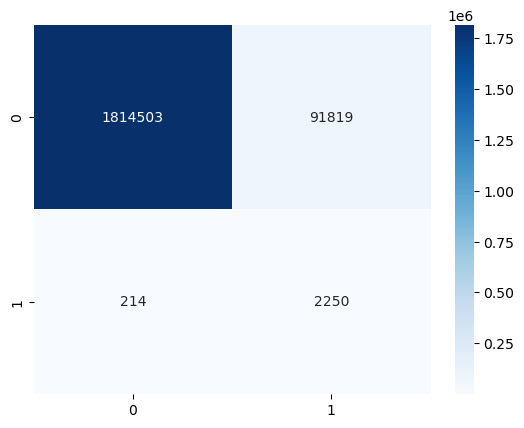

In [63]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap="Blues")
plt.show()

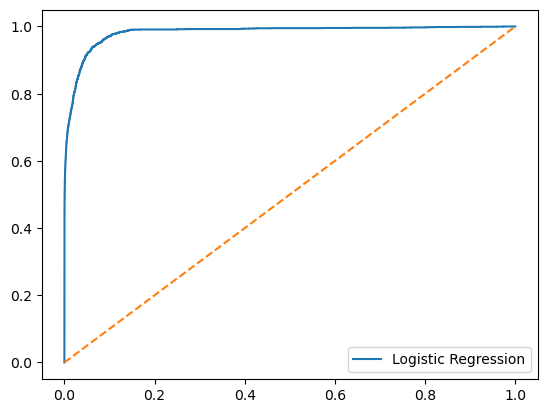

In [64]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

### Model Evaluation Output

The Logistic Regression model was evaluated on the test set:

- **Non-fraud transactions:** Predicted very accurately.  
- **Fraud transactions:** Detected partially; recall and F1-score are lower due to class imbalance.  
- **ROC-AUC:** High, showing the model can rank transactions by fraud probability effectively.



### Moving to Advanced Models for Better Fraud Detection

The Logistic Regression model detected most fraud cases but had many false positives due to class imbalance.  

To improve performance, I will train **Random Forest** **advance model** which can:  
- Capture complex, nonlinear relationships between features.  
- Handle class imbalance effectively using class weights or oversampling.  
- Provide feature importance to understand which variables are most predictive of fraud.  

These models are expected to increase recall and F1-score for fraud while maintaining high ROC-AUC.


In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
! pip install imbalanced-learn

### Handling Class Imbalance with SMOTE

I used **SMOTE (Synthetic Minority Oversampling Technique)** to balance the dataset:

- Generates synthetic samples for the minority class (fraud) in the training set.  
- Produces `X_train_res` and `y_train_res`, a balanced version of the training data.  
- Helps the model learn fraud patterns more effectively without losing majority-class information.


In [72]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


### Initializing the Random Forest Model

I created a **Random Forest classifier** with the following settings:

- `n_estimators=200` → uses 200 decision trees for better accuracy.  
- `class_weight="balanced"` → handles class imbalance by giving more weight to fraud cases.  
- `n_jobs=-1` → uses all CPU cores to speed up training.  
- `random_state=42` → ensures reproducible results.


In [75]:
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1, random_state=42)


### Training the Random Forest Model

I trained the Random Forest on the balanced training data (`X_train_res`, `y_train_res`) generated by SMOTE.  

- The model learns patterns from both majority (non-fraud) and minority (fraud) classes.  
- Training may take longer due to the large dataset and number of trees, but it ensures better fraud detection.


In [77]:
rf.fit(X_train_res, y_train_res) 

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [78]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

In [79]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      1.00      0.98      2464

    accuracy                           1.00   1908786
   macro avg       0.98      1.00      0.99   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC: 0.9991785674321287
[[1906225      97]
 [      9    2455]]


### Random Forest Model Performance

The Random Forest model was evaluated on the test set and shows excellent performance:

- **Non-fraud transactions:** Almost all correctly predicted (TN = 1,906,225).  
- **Fraud transactions:** Nearly all detected (TP = 2,455), with very few missed (FN = 9).  
- **Precision (fraud):** 0.96 → most predicted frauds are correct.  
- **Recall (fraud):** 1.00 → nearly all actual frauds detected.  
- **F1-score (fraud):** 0.98 → excellent balance between precision and recall.  
- **ROC-AUC:** 0.999 → the model can almost perfectly distinguish fraud from non-fraud.

**Conclusion:**  
The Random Forest model outperforms Logistic Regression and is highly reliable for detecting fraud in this dataset.


In [80]:
import joblib

# Save model
joblib.dump(rf, "random_forest_fraud_model.pkl")

['random_forest_fraud_model.pkl']

In [81]:
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

### Saving the Trained Model and Scaler

After training, I saved the Random Forest model and the StandardScaler to reuse them later:

- **Random Forest model:**  
  - Saved as `random_forest_fraud_model.pkl` using `joblib.dump`.  
  - Can be loaded later to make predictions without retraining.  

- **Scaler:**  
  - Saved as `scaler.pkl` to ensure new data is scaled the same way as the training set.  

This makes the workflow reproducible and ready for deployment.
